In [1]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import Tiff32Image

In [2]:
NUMBER_OF_NEAR_BANDS = 12
SELECTED_WIDTH = 128

# from save_autoencoder_images:
MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22 

## Load

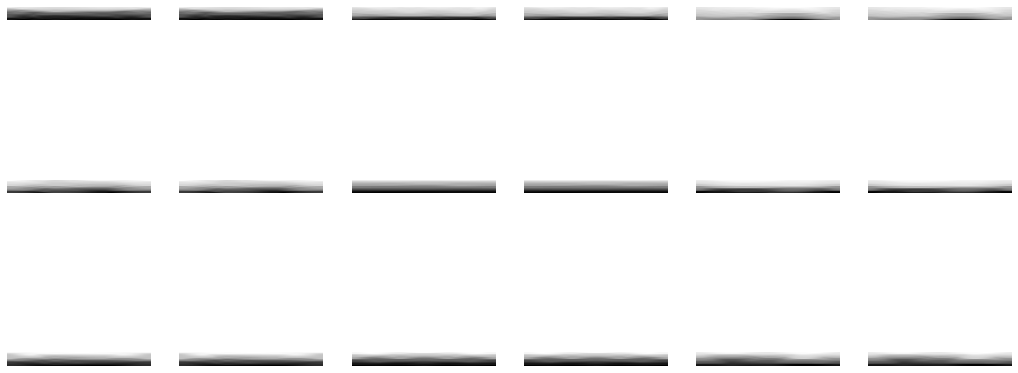

In [3]:
dls = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[Resize((12, SELECTED_WIDTH), "squish")],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        ).dataloaders(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands", bs=64)

dls.show_batch()

## Train

### Create Learner

In [4]:
from models import conv, deconv

class SimpleAutoencoder(nn.Module):
    def __init__(self, n_latent=128, norm=False):
        super().__init__()
        self.encode = nn.Sequential(
            conv(1, 4, norm=norm), # 6x64
            conv(4, 8, norm=norm), # 3x32
            nn.Flatten(),
            nn.Linear(3*32*8, n_latent),
            nn.Tanh(),
        )
        
        self.decode_linear=nn.Sequential(
            nn.Linear(n_latent, 8*3*32),
            nn.BatchNorm1d(8*3*32),
            nn.ReLU(),
        )
        
        self.decode = nn.Sequential(
            deconv(8, 4, norm=norm), # 6x64
            deconv(4, 1, norm=norm, act=False), # 12x128
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        out = self.encode(x)
        out = self.decode_linear(out)
        out = out.view(-1, 8, 3, 32)
        return self.decode(out)

epoch,train_loss,valid_loss,time
0,0.006306,0.005895,00:06
1,0.003319,0.006055,00:06
2,0.001671,0.012774,00:07
3,0.001068,0.003405,00:06
4,0.000746,0.003818,00:06
5,0.000487,0.002598,00:06
6,0.000367,0.000610,00:06
7,0.000295,0.001229,00:06
8,0.000265,0.000637,00:05
9,0.000240,0.000505,00:06


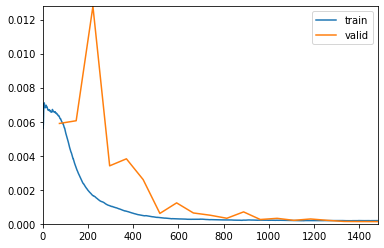

In [8]:
ae = SimpleAutoencoder(n_latent=128)
learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
learn.fit_one_cycle(20)

## View Predictions

array([<AxesSubplot:title={'center':'Input'}>,
       <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object)

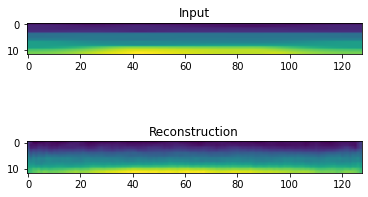

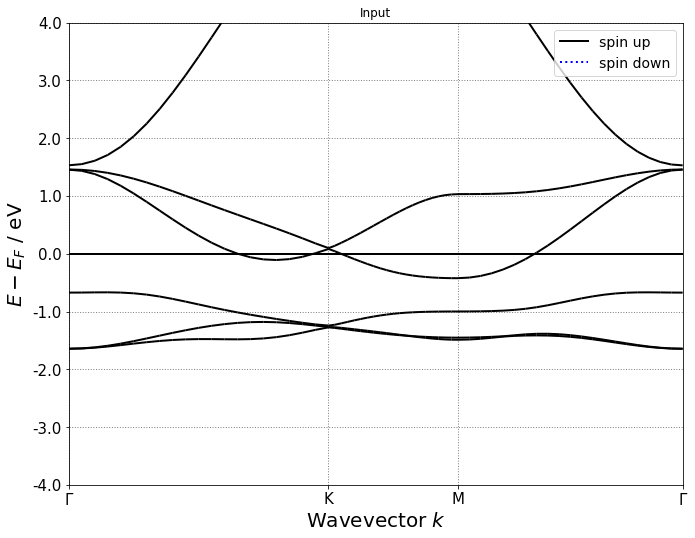

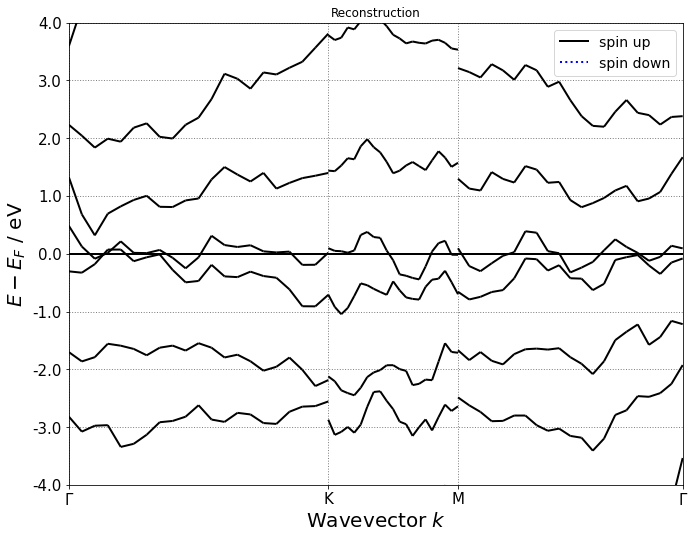

In [9]:
view_prediction("2dm-1", learn.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH)